# **Introduction to DL -- Evaluation, Generalization, and Optimization Algorithms**

<img src="https://incubator.ucf.edu/wp-content/uploads/2023/07/artificial-intelligence-new-technology-science-futuristic-abstract-human-brain-ai-technology-cpu-central-processor-unit-chipset-big-data-machine-learning-cyber-mind-domination-generative-ai-scaled-1-1500x1000.jpg" width="600"/>


<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2025/blob/main/practicals/ML_Foundation/Part_3/Machine_learning_evaluation_and_generalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


© Deep Learning Indaba 2025. Apache License 2.0.

**Authors:** Ulrich Mbou Sob, Geraud Nangue Tasse

**Reviewers:**

**Introduction:**
In machine learning, our main goal is to **train a model on data** so that it can perform well at a specific task such as **classification** or **regression**.

When training a model, we typically minimize a **loss function**. The loss guides the learning process, but it doesn’t always align with how we actually evaluate performance on the intended task. In this tutorial, we will explore different approaches to evaluating machine learning models and introduce various optimization techniques that can be leveraged to improve their performance.

**Topics:**

Content: <font color='green'>`Supervised Learning, Evaluation, Optimization`</font>

Level: <font color='grey'>`Beginner`</font>

**Aims/Learning Objectives:**

In this tutorial we will learn the following key concepts:

- **Model Evaluation** → How do we measure how good a model really is?  
- **Generalization** → How well does a model perform on data it has never seen before?  
- **Optimization & Regularization** → What algorithms and techniques can we use to train models more efficiently and prevent overfitting?

**Prerequisites:**

- Practical 1
  - Regression
  - Basic knowledge of Jax
- Practical 2
  - Machine learning classification

**Outline:**

>[Introduction to DL -- Evaluation, Generalization, and Optimization Algorithms](#scrollTo=f8vAhgUlCrhn)

>>[Installation and Imports](#scrollTo=Ua49uaQKFSGQ)

>>[Helper functions (Run Cell)](#scrollTo=QeUWtf7PtE-K)

>>[Part 1 — Evaluation and Generalization](#scrollTo=zHc7_PbomVIN)

>>>[Model Evaluation](#scrollTo=nHCa0Tj-0_ZC)

>>>[Breast cancer classification](#scrollTo=VnKyBQeS7auc)

>>>[Evaluation metrics](#scrollTo=S8cWX6wEe0rN)

>>>>[✅ Accuracy](#scrollTo=nw5RpOOekkII)

>>>>[🎯 Precision](#scrollTo=41S2rXHulrai)

>>>>[🚨 Recall (Sensitivity)](#scrollTo=BshBAzvElsyw)

>>>>[📊 Aggregate Metrics](#scrollTo=aUlfhmD9tED-)

>>>[Cross validation and Generalisation](#scrollTo=KpjY8k_64kjT)

>>[Part 2 — Optimization Algorithms](#scrollTo=5HNpEM4DnMNe)

>>>[Parameter Initialization](#scrollTo=xprTxw9s4BCo)

>>>>[1.1 Random Initialization](#scrollTo=Gy3rT0eqBNYa)

>>>>[1.2 He Initialisation (and Xavier)](#scrollTo=g05u_7iXF6NL)

>>>[Gradient Steps Optimisation](#scrollTo=4owuWGJDHT8a)

>>>>[2.1 Effect of Learning Rate](#scrollTo=8jvzMdwRHYn2)

>>>>[2.2 Momentum](#scrollTo=INHNJNakHtHf)

>>>>[2.3 Adam Optimizer](#scrollTo=rZyAEH_zIED7)

>>>[Regularisation](#scrollTo=BIGSComnIgLR)

>>>>[3.1 L2 Regularisation (Weight Decay)](#scrollTo=FdpZtxRoIjhQ)

>>>>[3.2 Early Stopping](#scrollTo=DoarzCZlI5fi)

>>>>[3.3 Other approaches (briefly)](#scrollTo=hlEtTtPfJGFR)

>>>[Wrap-up](#scrollTo=6tpSuRDAJIZ-)

>>[Appendix](#scrollTo=8dmPgHGhH8oU)

>>[References](#scrollTo=d6YYbpyXpqib)

>>[Feedback](#scrollTo=o1ndpYE50BpG)

**Note:** To get the most out of this tutorial, try answering the questions, quizzes, and code tasks on your own before checking the solutions. Actively working through them is the most effective way to learn.

**Before you start:**

Run the "Installation and Imports" cell below.

### Installation and Imports

In [1]:
!pip install jax flax optax clu --quiet

import numpy as np
import random
import matplotlib.pyplot as plt
from flax import nnx
import jax
import jax.numpy as jnp
import pandas as pd
import copy
import math
from matplotlib import cm
import tensorflow as tf
import optax
import flax
from clu import metrics
from flax import struct
import flax.linen as nn
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.7 MB/s eta 0:00:00


### Helper functions (Run Cell)

In [11]:
from IPython.display import clear_output
from flax.core import freeze, unfreeze

@struct.dataclass
class TrainMetrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')

@struct.dataclass
class EvalMetrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')

def train_step(params, model, optimizer, opt_state, loss_grad_fn, metrics, batch):
  """Train for a single step."""
  (loss, logits), grads = loss_grad_fn(params, model, batch)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  labels = batch[1].astype(jnp.int32)
  metric_updates = TrainMetrics.single_from_model_output(
    logits=logits, labels=labels, loss=loss)

  metrics = metrics.merge(metric_updates)
  return params, opt_state, metrics

def eval_step(params, model, loss_fn, metrics, batch):
  loss, logits = loss_fn(params, model, batch)
  labels = batch[1].astype(jnp.int32)
  metric_updates = EvalMetrics.single_from_model_output(
    logits=logits, labels=labels, loss=loss)

  metrics = metrics.merge(metric_updates)
  return metrics


def train(
    epochs, params, model, optimizer, opt_state, loss_grad_fn,
    loss_fn, train_ds, test_ds, metrics_history, plot_now=True
  ):

  train_metrics = TrainMetrics.empty()
  eval_metrics = EvalMetrics.empty()

  for i in range(epochs):
    for step, batch in enumerate(train_ds.as_numpy_iterator()):
      params, opt_state, train_metrics = train_step(params, model, optimizer, opt_state, loss_grad_fn, train_metrics, batch)

      for metric, value in train_metrics.compute().items():
        metrics_history[f"train_{metric}"].append(value)

      for _, full_test_batch in enumerate(test_ds.as_numpy_iterator()):
        eval_metrics = eval_step(params, model, loss_fn, eval_metrics, full_test_batch)

      for metric, value in eval_metrics.compute().items():
        metrics_history[f"test_{metric}"].append(value)

  if plot_now:
    plot_metrics([metrics_history], [""])

  return params, opt_state, metrics_history


# Recursively print all parameter names and their shapes
def print_param_shapes(params, prefix=""):
    for key, val in params.items():
        if isinstance(val, dict):
            print_param_shapes(val, prefix=f"{prefix}{key}/")
        else:
            print(f"{prefix}{key}: shape={val.shape}")

def plot_metrics(metrics_histories, labels, metric="loss"):
    """
    Plot training and test metrics for multiple histories.

    Args:
        metrics_histories (list[dict]): Each dict contains train/test metrics history
                                        e.g. metrics_history['train_loss'], ['test_loss']
        labels (list[str]): Labels for each run (e.g. 'Model A', 'Model B')
        metric (str): Metric to plot (default: 'loss')
    """
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(7, 5))
    colors = ['blue', 'orange', 'green', 'pink', 'black']
    nc = len(colors)

    for i, (history, label) in enumerate(zip(metrics_histories, labels)):
        # train curve (solid)
        ax.plot(history[f"train_{metric}"], label=f"{label} train", color=colors[i%nc], alpha=0.5)
        # test curve (dashed, same color as train)
        ax.plot(history[f"test_{metric}"], linestyle="--", label=f"{label} test", color=colors[i%nc])

    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Iteration")
    ax.legend()
    plt.show()

## Evaluation and Generalization

### Model Evaluation

In simple terms:  
- **Evaluation** tells us how well our model is performing on a given dataset.  
- **Generalization** tells us how well the model can perform on data it has never seen before.  

Our goal is not just to build a model that performs well on the **training data**, but one that learns the **underlying patterns in the data**.  
This way, it can make good predictions on **unseen examples** — and even handle slightly different (out-of-distribution) cases.


#### **Breast cancer classification**
For this section, we will revisit the breast cancer classification task from Part 2 of the practicals. However, we will pay more attention and focus on the performance of our model.

Let's load the data.

In [3]:
from sklearn.datasets import load_breast_cancer

# Load breast cancer dataset from sklearn
data = load_breast_cancer()

# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable to the DataFrame
# We reverse here because sklearn stores "Malignant" which is cancerous as 0
# and Benign non cancerous as 1
df['target'] = 1 - data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
# Check the proportion of 1s and 0s
proportion = df["target"].value_counts(normalize=True)

print("Counts:\n", df["target"].value_counts())
print("\nProportions:\n", proportion)

Counts:
 target
0    357
1    212
Name: count, dtype: int64

Proportions:
 target
0    0.627417
1    0.372583
Name: proportion, dtype: float64


🤔 **Pause and reflect:** If we look at the proportions of our labels more then 62% belong to one class. How do you think this can affect the performance of our model?

In [6]:
# split dataset into test and train
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df["target"])

# split each set into input and target
y_train = train_set.pop('target').astype(np.int32)
x_train = train_set

y_test = test_set.pop('target').astype(np.int32)
x_test = test_set

print(f"training data input shape {x_train.shape}")
print(f"training target shape {y_train.shape}")

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

training data input shape (455, 30)
training target shape (455,)


Before diving into different evaluation metrics let implement and train a model with out datasets. The [helper functions](#scrollTo=QeUWtf7PtE-K) contain the training loop function we will use.

💻 Code Task: Train a Multi-Layer Perceptron (MLP) Binary Classifier.

Your goal is to complete the definition of an MLP model using Flax’s Linen API. This model will take input features from a tumor dataset and output a single logit representing the probability whether the tumor is malignant or benign (binary classification).

You'll implement the model by completing the __call__ method of the MLP class.

1. Architecture

   - Design your own architecture using activation functions we learned previously.
   - The input to your MLP should be a list of hidden layers. Previously we passed each hidden layer separately.

2. Implement the loss function.

   - Use the binary cross entropy loss.

3.  Call the training loop.

In [ ]:
import flax.linen as nn

class MLP(nn.Module):

  layer_sizes: list  # e.g., [64, 32, 10, 1] (hidden layers + output layer)

  @nn.compact
  def __call__(self, x):

    # Implement the various hidden layers with your choosen activation functions
    # Hint: loop through all the hidden layers first. Then implement the output layer outside of the for loop.
    for size ... # update me
      x =  ... # update me



    # Output layer
    x = ... # update me


    return x

In [7]:
# @title 🔓Solution - MLP in Jax(Try not to peek until you've given it a good try!')
class MLP(nn.Module):
  layer_sizes: list  # e.g., [64, 32, 10, 1] (hidden layers + output layer)

  @nn.compact
  def __call__(self, x):
      # Apply all hidden layers with GeLU
      for size in self.layer_sizes[:-1]:
          x = nn.Dense(size)(x)
          x = nn.gelu(x)

      # Output layer (no activation)
      x = nn.Dense(self.layer_sizes[-1])(x)
      return x

In [8]:

def get_model_and_optimizer(input_size, output_sizes=None, seed=32, lr=1e-3):
  # Helper function to quickly initialise MLP models
  # output sizes is list of different output layer e.g. [10,10,1]
  # the final value in the output size should be 1 since this what we want for our MLP

  model = MLP(output_sizes)

  key = jax.random.PRNGKey(seed)

  dummy_data = jnp.zeros((1, input_size), dtype=float)


  params = model.init(key, dummy_data)

  # Print model parameters
  print_param_shapes(params['params'])

  optimizer = optax.adam(learning_rate=lr)
  opt_state = optimizer.init(params)

  return model, params, optimizer, opt_state


In [ ]:
def loss_func(params, model, batch):
  """Compute the sigmoid binary cross-entropy loss and return logits."""

  # Extract inputs and labels from batch
  inputs = batch[0]
  labels = batch[1]

  # Compute logits
  logits = model.apply(params, inputs)

  # Calculate the logits
  labels = jnp.reshape(labels, logits.shape) # Reshape the labels to match the shape of the logits.

  # Compute binary cross-entropy loss
  loss = ... # update me

  return loss, logits

# Define the value_and_grad function using jax.value_and_grad
loss_grad_fn = ... # update me

In [9]:
# @title 🔓Solution - loss and grads computations (Try not to peek until you've given it a good try!')
def loss_func(params, model, batch):
  # Your code here
  inputs = batch[0]
  labels = batch[1]

  logits = model.apply(params, inputs)
  labels = jnp.reshape(labels, logits.shape)
  loss = optax.sigmoid_binary_cross_entropy(
      logits=logits, labels=labels
  ).mean()
  return loss, logits

# Define the value_and_grad function using jax.value_and_grad
loss_grad_fn = jax.value_and_grad(loss_func, has_aux=True)

In [ ]:
batch_size = 32 # you can modify this if you wish
epochs = 100 # you can modify this if you wish
seed = 32 # you can modify this if you wish
lr = 1e-3 # you can modify this if you wish

metrics_history = {
    "train_loss": [],
    "test_loss": [],
}

train_ds = train_dataset.shuffle(1000).batch(batch_size)
test_batch_size = len(test_dataset)
test_ds = test_dataset.batch(test_batch_size)

input_size = 30
output_sizes = ... # update this based on your MLP design
model, params, optimizer, opt_state = get_model_and_optimizer(input_size, output_sizes, seed=seed, lr=lr)

params, opt_state, metric_history = train(epochs, params, model, optimizer, opt_state,
                                          loss_grad_fn, loss_func, train_ds, test_ds, metrics_history)


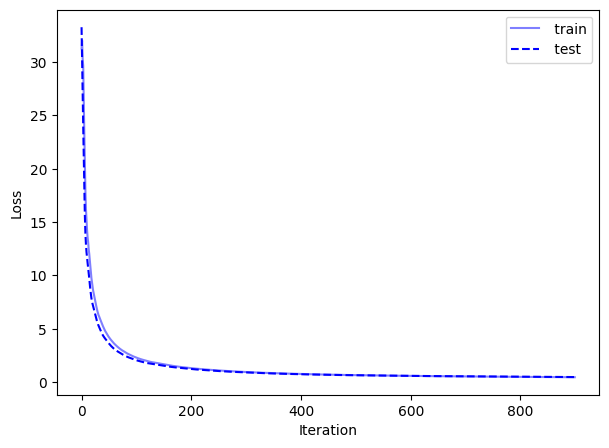

In [17]:
# @title 🔓Solution - calling the training loop (Try not to peek until you've given it a good try!')
batch_size = 32
epochs = 60

metrics_history = {
    "train_loss": [],
    "test_loss": [],
}

train_ds = train_dataset.shuffle(1000).batch(batch_size)
test_batch_size = len(test_dataset)
test_ds = test_dataset.batch(test_batch_size)

input_size = 30
output_sizes = [30,30,20,1]
model, params, optimizer, opt_state = get_model_and_optimizer(input_size, output_sizes, seed=32, lr=1e-3)

params, opt_state, metric_history = train(epochs, params, model, optimizer, opt_state,
                                          loss_grad_fn, loss_func, train_ds, test_ds, metrics_history)


#### Evaluation metrics

Now that we have trained our model, we will use different metrics to gauge the performance of our model.

💻 Code Task: Implement a prediction function for our model.
This function should take as input, the model, the paramemters, input features and a threshold for classification. This should return a label 0 or 1 for each input's features.

In [ ]:
def predict(params, model, x, threshold=0.5):
    """
    Apply model and return class predictions based on threshold.

    Args:
        params: trained model parameters
        model: Flax MLP model
        x: input array
        threshold: decision threshold (default=0.5)

    Returns:
        jnp.array of predictions (0 or 1)
    """
    logits = model.apply... # update me
    probs = ... # update me
    preds = ... # update me using threshold


    return preds.squeeze()

In [12]:
# @title 🔓Solution - calling the training loop (Try not to peek until you've given it a good try!')
def predict(params, model, x, threshold=0.5):
    """
    Apply model and return class predictions based on threshold.

    Args:
        params: trained model parameters
        model: Flax MLP model
        x: input array
        threshold: decision threshold (default=0.5)

    Returns:
        jnp.array of predictions (0 or 1)
    """
    logits = model.apply(params, x)

    probs = nn.sigmoid(logits)
    preds = (probs >= threshold).astype(jnp.int32).squeeze()

    return preds

Let define the most common metrics used in classification tasks.

#### ✅ Accuracy

Accuracy measures the proportion of correct predictions out of total predictions:

$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
$$

While useful, accuracy can be **misleading**, especially on **imbalanced datasets**. Imagine if only 5% of tumors are malignant. A model that always predicts "benign" will still have 95% accuracy, but be completely useless.

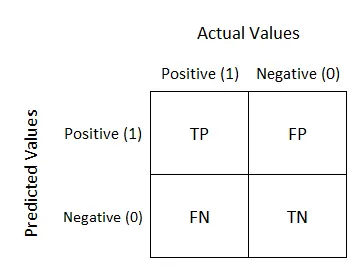

**Confusion matrix**: [Image source](https://medium.com/data-science/understanding-confusion-matrix-a9ad42dcfd62)

While **accuracy** is the most intuitive and commonly used metric for classification tasks, it has limitations as mentioned above. To address these, other evaluation metrics are derived from the **confusion matrix**.  

The confusion matrix provides a breakdown of predictions into four categories:  

- **True Positives (TP)** – the model predicts positive and it is actually positive.  
- **False Positives (FP)** – the model predicts positive but it is actually negative.  
- **False Negatives (FN)** – the model predicts negative but it is actually positive.  
- **True Negatives (TN)** – the model predicts negative and it is actually negative.  

A **perfect confusion matrix** would have all off-diagonal entries equal to 0.  


#### 🎯 Precision

Precision tells us the **fraction of labels** predicted as **positive** that are truely **positive**:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Useful when **false positives** are **costly**, e.g., incorrectly diagnosing a healthy patient as having cancer.

#### 🚨 Recall (Sensitivity)

Recall tells us **how many actual positives** were predicted correctly:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Important when **missing a true positive case is dangerous** e.g. failing to identify a malignant tumor.

💻 Code Task: Complete the functions below to implement the above 3 metrics, accuracy, precision and recall.

In [ ]:
def accuracy(y_true, y_pred):
    """Compute accuracy = correct predictions / total"""
    acc = ... # update me
    return acc


def precision(y_true, y_pred):
    """Compute precision = TP / (TP + FP)"""
    tp = ... # update me -- true positve
    fp = ... # update me -- false positive
    result = ... # update me

    return result


def recall(y_true, y_pred):
    """Compute recall = TP / (TP + FN)"""
    tp = ... # update me -- true positve
    fn = ... # update me -- false negative
    result = ... # update me

    return result


In [13]:
# @title 🔓Solution - accuracy, precision, recall (Try not to peek until you've given it a good try!')
def accuracy(y_true, y_pred):
    """Compute accuracy = correct predictions / total"""
    return jnp.mean(y_true == y_pred)

def precision(y_true, y_pred):
    """Compute precision = TP / (TP + FP)"""
    tp = jnp.sum((y_true == 1) & (y_pred == 1))
    fp = jnp.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp + 1e-8)  # add epsilon to avoid division by zero


def recall(y_true, y_pred):
    """Compute recall = TP / (TP + FN)"""
    tp = jnp.sum((y_true == 1) & (y_pred == 1))
    fn = jnp.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn + 1e-8) # add epsilon to avoid division by zero

Let compute these metrics on test and training sets.

In [18]:
ypreds_train = predict(params, model, x_train, threshold=0.5)
ypreds_test = predict(params, model, x_test, threshold=0.5)

# convert this to numpy from dataframes
# create a new variable to avoid overwriting previous if we need to call this function multiple times
y_train_tmp = jnp.array(y_train.to_numpy())
y_test_tmp = jnp.array(y_test.to_numpy())

train_acc = accuracy(y_train_tmp, ypreds_train)
test_acc = accuracy(y_test_tmp, ypreds_test)

train_precision = precision(y_train_tmp, ypreds_train)
train_recall = recall(y_train_tmp, ypreds_train)

test_precision = precision(y_test_tmp, ypreds_test)
test_recall = recall(y_test_tmp, ypreds_test)

print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy {test_acc:.4f}")
print(f"Train Precision: {train_precision:.4f}, Test Precision {test_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}, Test Recall {test_recall:.4f}")

Train Accuracy: 0.9209, Test Accuracy 0.8860
Train Precision: 0.9926, Test Precision 1.0000
Train Recall: 0.7941, Test Recall 0.6905


🤔 Pause and reflect: What can you say about your model performance?

Is your model performing similarly on the training set and the test set?

Are you satisified with your precision and recall scores given their implications?

How can we improve our model?

#### 📊 Aggregate Metrics
In the preciding section, we define various metrics which can be analysed independently. Most often in machine learning and science studies, we want to summarise with a single number that can tell the entire story. Now we look at few other metrics that try exactly to do that.

**ROC Curve**

The **Receiver Operating Characteristic (ROC) curve** shows how well a binary classifier can separate the two classes across different thresholds.  
- The x-axis is the **False Positive Rate (FPR)**  
- The y-axis is the **True Positive Rate (TPR / Recall)**  
- The closer the curve is to the **top-left corner**, the better the model.  
- The **Area Under the Curve (AUC)** summarizes performance:  
  - AUC = 1 → perfect classifier  
  - AUC = 0.5 → random guessing

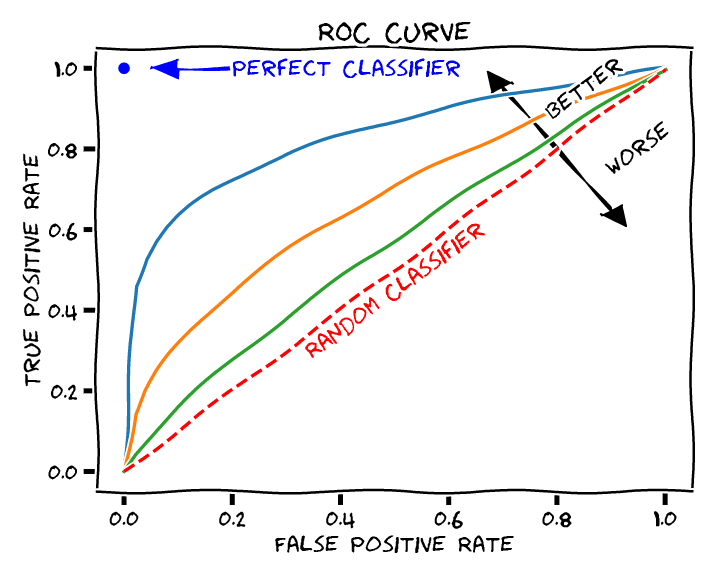

ROC curve: [Image source](https://sefiks.com/2020/12/10/a-gentle-introduction-to-roc-curve-and-auc/)

**F1-Score**

The **F1-score** balances **precision** and **recall** in one number.  
It is useful when classes are imbalanced.  
$$
F1 = \frac{2 \cdot (\text{Precision} \cdot \text{Recall})}{\text{Precision} + \text{Recall}} = \frac{2TP}{2TP + FP + FN}
$$

- High F1-score means the model has both **good precision** (few false positives) and **good recall** (few false negatives).  
- Useful for medical tasks like cancer detection where both errors matter.

**Matthews Correlation Coefficient (MCC)**

The **MCC** is a more balanced evaluation metric that uses all four confusion matrix values i.e. TP, TN, FP, and FN.  

$$
\text{MCC} = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
$$

- MCC = +1 → perfect prediction  
- MCC = 0 → random prediction  
- MCC = -1 → total disagreement  

Both F1-score and MCC are particularly good for **imbalanced datasets**, where accuracy alone can be misleading.

💻 Code Task: Complete the functions below to implement the F1 score and the MCC.

In [ ]:
def f1_score(y_true, y_pred):
    p = ... # update me -- precision
    r = ... # update me -- recall
    result = ... # update me
    return result

def matthews_corrcoef(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = ... # update me --- false positive
    fn = ... # update me --- false negative

    numerator = (tp * tn) - (fp * fn)
    denominator = ... # update me
    return numerator / denominator

In [19]:
# @title 🔓Solution - F1-score and MCC (Try not to peek until you've given it a good try!')
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + 1e-8)

def matthews_corrcoef(y_true, y_pred):
    tp = float(np.sum((y_true == 1) & (y_pred == 1)))
    tn = float(np.sum((y_true == 0) & (y_pred == 0)))
    fp = float(np.sum((y_true == 0) & (y_pred == 1)))
    fn = float(np.sum((y_true == 1) & (y_pred == 0)))

    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn) + 1e-8)
    return numerator / denominator

Let's compute the F1 score and MCC of our model

In [20]:
train_f1_score = f1_score(y_train_tmp, ypreds_train)
test_f1_score = f1_score(y_test_tmp, ypreds_test)

train_mcc = matthews_corrcoef(y_train_tmp, ypreds_train)
test_mcc = matthews_corrcoef(y_test_tmp, ypreds_test)

print(f"Train f1 score: {train_f1_score:.4f}, Test f1 score {test_f1_score:.4f}")
print(f"Train MCC: {train_mcc:.4f}, Test MCC {test_mcc:.4f}")

Train f1 score: 0.8824, Test f1 score 0.8169
Train MCC: 0.8355, Test MCC 0.7648


🤔 Pause and reflect: What can you say about your model performance based on these metrics?


### Cross validation and Generalisation

In the previous sections we discussed different metrics which can be use to measure the performance of machine learning models in classification tasks.

So far we've used an approach where we split the data into a fixed training and test set. This implies we are using a fixed test set to measure the generalisation ability of the model.

🤔 Pause and reflect: What approach can we use in our train/test splitting strategy to improve model generalisation?


**Cross-validation** is a popular machine learning technique used to test the **generalization capability** of models.  

In this approach, we split the dataset into several parts (called *folds*). The model is trained on some of these folds and tested on the remaining ones. This process is repeated so that each fold serves as the test set once. Finally, we evaluate the model’s performance on each test set and take the **average score** as the overall performance.  

📖 You can read more about different cross-validation techniques [here](https://www.geeksforgeeks.org/machine-learning/cross-validation-machine-learning/).


**Test your understanding**: Below is a quiz to help us revise our understanding of these metrics and how to apply them in different situations. Note that some questions also include metrics for regression tasks, which we did not explain here but were introduced in the first practical session.

In [ ]:
# @title 🔓Quiz
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# QUIZ DATA
# -----------------------------
quiz = [
    {
        "question": "Q1. Model A has accuracy = 92%, Model B = 89% but lower false negatives. "
                    "Which is better for medical diagnosis?",
        "options": ["A. Model A", "B. Model B", "C. Either one", "D. Both are equally good"],
        "answer": 1,
        "explanation": "In medical diagnosis, recall (avoiding false negatives) matters more than raw accuracy."
    },
    {
        "question": "Q2. Model A: Precision=0.95, Recall=0.60. Model B: Precision=0.70, Recall=0.90. "
                    "Which is better for fraud detection?",
        "options": ["A. Model A", "B. Model B", "C. Both are the same", "D. Depends on dataset size"],
        "answer": 1,
        "explanation": "Fraud detection requires catching as many fraudulent cases as possible (high recall)."
    },
    {
        "question": "Q3. Model A: False Positive Rate=0.05. Model B: False Positive Rate=0.15. "
                    "Which is better for spam detection?",
        "options": ["A. Model A", "B. Model B", "C. Both are equal", "D. Can't decide without precision"],
        "answer": 0,
        "explanation": "A lower false positive rate means fewer legitimate emails flagged as spam."
    },
    {
        "question": "Q4. Model A: AUC=0.81. Model B: AUC=0.87. Which has better discrimination ability?",
        "options": ["A. Model A", "B. Model B", "C. Both are equal", "D. AUC not relevant"],
        "answer": 1,
        "explanation": "A higher AUC means the model separates classes better."
    },
    {
        "question": "Q5. Class imbalance (1% positive). Model A: Accuracy=99%, Recall=0%. "
                    "Model B: Accuracy=95%, Recall=85%. Which is more useful?",
        "options": ["A. Model A", "B. Model B", "C. Both equal", "D. Depends on precision"],
        "answer": 1,
        "explanation": "Model A ignores the minority class. Model B captures positives, so it's more useful."
    },
    {
        "question": "Q6. Model A: MAE=2.5. Model B: RMSE=2.8. Which handles large errors better?",
        "options": ["A. Model A", "B. Model B", "C. Both equal", "D. Need more info"],
        "answer": 1,
        "explanation": "RMSE penalizes large errors more strongly."
    },
    {
        "question": "Q7. Model A: R²=0.72. Model B: R²=0.65. Which explains more variance?",
        "options": ["A. Model A", "B. Model B", "C. Both equal", "D. R² doesn’t measure variance"],
        "answer": 0,
        "explanation": "A higher R² means more variance explained."
    },
    {
        "question": "Q8. Model A: High training acc, low test acc. Model B: Lower training acc, higher test acc. "
                    "Which should you deploy?",
        "options": ["A. Model A", "B. Model B", "C. Both equal", "D. Depends on training acc"],
        "answer": 1,
        "explanation": "Generalization matters more; Model B overfits less."
    },
    {
        "question": "Q9. Model A: 1% higher accuracy but 10x slower. Model B: Slightly less accurate but faster. "
                    "Which is better for real-time systems?",
        "options": ["A. Model A", "B. Model B", "C. Both equal", "D. Accuracy always first"],
        "answer": 1,
        "explanation": "Speed is critical in real-time systems; Model B is preferable."
    },
    {
        "question": "Q10. Model A: Best accuracy, black box. Model B: Slightly worse but interpretable. "
                    "Which is better in healthcare/finance?",
        "options": ["A. Model A", "B. Model B", "C. Both equal", "D. Accuracy only matters"],
        "answer": 1,
        "explanation": "Interpretability is crucial in regulated domains."
    },
    {
        "question": "Q11. Model A: Accuracy=95%, MCC=0.10. Model B: Accuracy=90%, MCC=0.65. "
                    "Which is better overall?",
        "options": ["A. Model A", "B. Model B", "C. Both equal", "D. Depends on recall"],
        "answer": 1,
        "explanation": "MCC is robust with imbalanced datasets. Model B is better overall."
    }
]


checkboxes = []
question_widgets = []

for q in quiz:
    # Question text displayed as HTML (so it's on top)
    question_label = widgets.HTML(value=f"<b>{q['question']}</b>")

    # Options below
    cb = widgets.RadioButtons(
        options=q["options"],
        layout={'width': 'max-content'}
    )

    # Group them vertically
    box = widgets.VBox([question_label, cb])

    question_widgets.append(box)
    checkboxes.append(cb)

submit_btn = widgets.Button(description="Submit", button_style="success")
output = widgets.Output()

def on_submit(b):
    with output:
        clear_output()
        for i, cb in enumerate(checkboxes):
            print(quiz[i]["question"])
            print("Your answer:", cb.value)
            correct = quiz[i]["options"][quiz[i]["answer"]]
            if cb.value == correct:
                print("✅ Correct!")
            else:
                print(f"❌ Wrong! Correct answer: {correct}")
            print("Explanation:", quiz[i]["explanation"])
            print("-"*70)

submit_btn.on_click(on_submit)

# Display questions nicely
for qw in question_widgets:
    display(qw)

display(submit_btn, output)



## Part 2 — Optimization Algorithms

In this part we’ll explore **how** we set parameters and **how** we update them so that training is stable, fast, and generalises well.

We’ll cover:
1) **Parameter initialization** (random vs. variance scaling like He/Xavier)  
2) **Gradient step optimisation** (learning rate, momentum, Adam)  
3) **Regularisation** (L2/weight decay, early stopping, and brief notes on other techniques)


### 1. Parameter Initialization

When training deep networks, parameter initialization matters because it controls the **variance of signals** as they propagate forward (activations) and backward (gradients). Poor choices lead to:
- **Vanishing** signals (too small), slowing learning.
- **Exploding** signals (too large), destabilising learning.

A good initialization keeps the variance of activations roughly constant across layers. We will explore various simple and state-of-the-art initialisation schemes, starting with plain random initialisation and then move to **variance scaling** (Xavier/Glorot and He/Kaiming) that preserves variance layer-to-layer under certain activations.


#### 1.1 Random Initialization

Most frameworks (like Flax) use normal or uniform random initializations by default.

💡 Idea: Let’s observe what happens when we initialize weights randomly.

To this end, let's wire `jax.random.normal` and `jax.random.normal` into our existing `get_model_and_optimizer`. Consider an MLP that takes the initialization type "kernel_init" as an additional argument.


In [21]:
class MLP(nn.Module):
    layer_sizes: list
    kernel_init: callable = nn.initializers.lecun_normal()  # default fallback

    @nn.compact
    def __call__(self, x):
        for size in self.layer_sizes[:-1]:
            x = nn.Dense(size, kernel_init=self.kernel_init)(x)
            x = nn.gelu(x)
        x = nn.Dense(self.layer_sizes[-1], kernel_init=self.kernel_init)(x)
        return x

**Exercise:** Modify `get_model_and_optimizer` so that:
- It accepts `init_type` in `{"normal", "uniform"}` plus two tunables: `normal_std` and `uniform_limit`.
- It passes the corresponding `kernel_init=` to each `nn.Dense`.
- Everything else remains the same (optimizer still Adam by default).

*Fill the `... # update me` spots; then run the tests cell.*

In [ ]:
#@title EXERCISE: Random initialisation inside get_model_and_optimizer

def normal_std(std=0.02):
    def _init(key, shape, dtype=jnp.float32):
        return ...  # update me:
    return _init

def uniform_range(limit=0.05):
    def _init(key, shape, dtype=jnp.float32):
        return ...  # update me:
    return _init

def get_model_and_optimizer(input_size,
                            output_sizes=None,
                            seed=32,
                            lr=1e-3,
                            init_type="normal",
                            normal_std_val=0.02,
                            uniform_limit_val=0.05):
    """
    Create MLP + Optax optimizer with configurable kernel initialization.
    init_type in {"normal","uniform"}.
    """
    # choose kernel_init based on init_type
    if init_type == "normal":
        kernel_init = normal_std(normal_std_val)
    elif init_type == "uniform":
        kernel_init = uniform_range(uniform_limit_val)
    else:
        kernel_init = nn.initializers.lecun_normal()

    model = MLP(output_sizes, kernel_init=kernel_init)
    key = jax.random.PRNGKey(seed)
    dummy = jnp.zeros((1, input_size), dtype=float)
    params = model.init(key, dummy)

    # Print model parameters
    print_param_shapes(params["params"])

    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(params)
    return model, params, optimizer, opt_state


In [22]:
#@title ✅ SOLUTION: Random initialisation inside get_model_and_optimizer

def normal_std(std=0.02):
    def _init(key, shape, dtype=jnp.float32):
        return std * jax.random.normal(key, shape, dtype)
    return _init

def uniform_range(limit=0.05):
    def _init(key, shape, dtype=jnp.float32):
        return jax.random.uniform(key, shape, dtype, minval=-limit, maxval=limit)
    return _init

def get_model_and_optimizer(input_size,
                            output_sizes=None,
                            seed=32,
                            lr=1e-3,
                            init_type="normal",
                            normal_std_val=0.02,
                            uniform_limit_val=0.05):
    if init_type == "normal":
        kernel_init = normal_std(normal_std_val)
    elif init_type == "uniform":
        kernel_init = uniform_range(uniform_limit_val)
    else:
        kernel_init = nn.initializers.lecun_normal()

    model = MLP(output_sizes, kernel_init=kernel_init)
    key = jax.random.PRNGKey(seed)
    dummy = jnp.zeros((1, input_size), dtype=float)
    params = model.init(key, dummy)

    print_param_shapes(params["params"])
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(params)
    return model, params, optimizer, opt_state


In [23]:
#@title 🔬 TEST: Build a model with random normal and uniform initialisation
batch_size = 32
train_ds = train_dataset.shuffle(1000).batch(batch_size)
test_ds  = test_dataset.batch(batch_size)

input_size = 30
output_sizes = [64, 64, 1]

# normal
model_n, params_n, opt_n, state_n = get_model_and_optimizer(
    input_size, output_sizes, seed=0, lr=1e-3, init_type="normal", normal_std_val=0.05)

# uniform
model_u, params_u, opt_u, state_u = get_model_and_optimizer(
    input_size, output_sizes, seed=0, lr=1e-3, init_type="uniform", uniform_limit_val=0.1)

print("OK: models initialised with normal and uniform.")


Dense_0/kernel: shape=(30, 64)
Dense_0/bias: shape=(64,)
Dense_1/kernel: shape=(64, 64)
Dense_1/bias: shape=(64,)
Dense_2/kernel: shape=(64, 1)
Dense_2/bias: shape=(1,)
Dense_0/kernel: shape=(30, 64)
Dense_0/bias: shape=(64,)
Dense_1/kernel: shape=(64, 64)
Dense_1/bias: shape=(64,)
Dense_2/kernel: shape=(64, 1)
Dense_2/bias: shape=(1,)
OK: models initialised with normal and uniform.


**Visualising initial activations across layers**

We push a batch of inputs through the untrained network and look at the **activation histograms** per layer. With poor initialisation you’ll see saturation (squashed near 0) or explosion (very wide).


Dense_0/kernel: shape=(30, 64)
Dense_0/bias: shape=(64,)
Dense_1/kernel: shape=(64, 64)
Dense_1/bias: shape=(64,)
Dense_2/kernel: shape=(64, 1)
Dense_2/bias: shape=(1,)
Dense_0/kernel: shape=(30, 64)
Dense_0/bias: shape=(64,)
Dense_1/kernel: shape=(64, 64)
Dense_1/bias: shape=(64,)
Dense_2/kernel: shape=(64, 1)
Dense_2/bias: shape=(1,)
Dense_0/kernel: shape=(30, 64)
Dense_0/bias: shape=(64,)
Dense_1/kernel: shape=(64, 64)
Dense_1/bias: shape=(64,)
Dense_2/kernel: shape=(64, 1)
Dense_2/bias: shape=(1,)


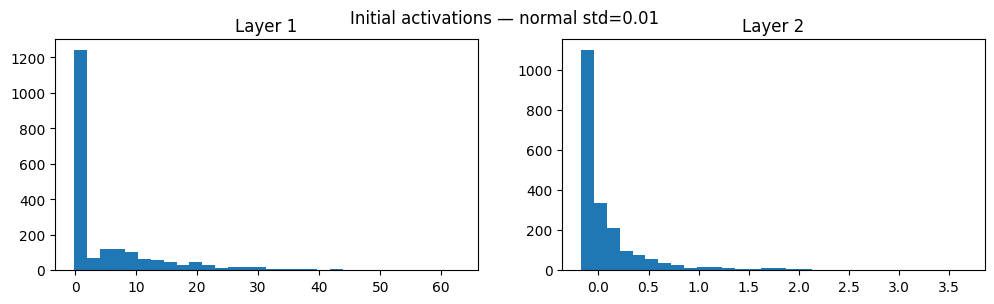

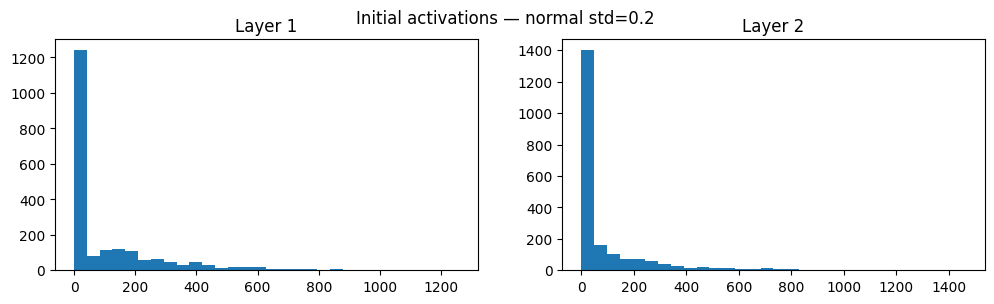

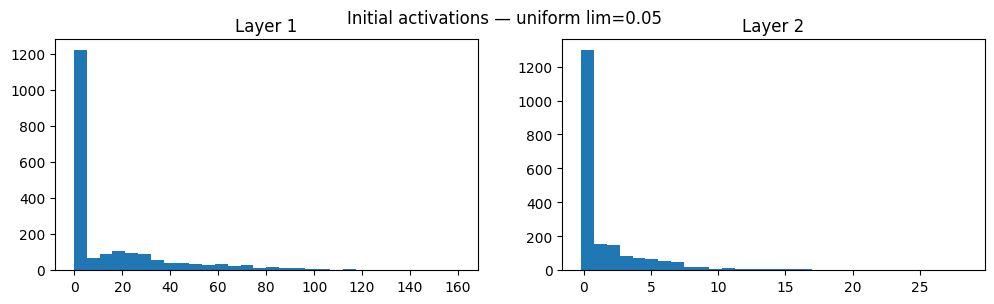

In [24]:
#@title Visualise initial activations layer-by-layer (fixed)
import numpy as np
import matplotlib.pyplot as plt

def forward_activations(params, model, x):
    acts = []
    variables = {"params": params["params"]}
    x0 = x
    for lyr, _ in enumerate(model.layer_sizes[:-1]):
        W = variables["params"][f"Dense_{lyr}"]["kernel"]
        B = variables["params"][f"Dense_{lyr}"]["bias"]
        x0 = jnp.dot(x0, W) + B
        x0 = jax.nn.gelu(x0)
        acts.append(np.asarray(x0))
    return acts

# --- get a small batch as a NumPy/JAX array ---
# Preferred: as_numpy_iterator (works on eager TF)
try:
    xb = next(train_ds.as_numpy_iterator())[0]   # (X_batch, y_batch) -> take features
except AttributeError:
    # Fallback: take(1) + .numpy()
    xb = next(iter(train_ds.take(1)))[0].numpy()
x_batch = jnp.array(xb)

# --- run with a few different inits ---
to_run = {
    "normal std=0.01": get_model_and_optimizer(
        input_size=30, output_sizes=[64,64,1], seed=1, lr=1e-3,
        init_type="normal", normal_std_val=0.01)[:2],
    "normal std=0.2": get_model_and_optimizer(
        input_size=30, output_sizes=[64,64,1], seed=1, lr=1e-3,
        init_type="normal", normal_std_val=0.2)[:2],
    "uniform lim=0.05": get_model_and_optimizer(
        input_size=30, output_sizes=[64,64,1], seed=1, lr=1e-3,
        init_type="uniform", uniform_limit_val=0.05)[:2],
}

for label, (m, p) in to_run.items():
    acts = forward_activations(p, m, x_batch)
    fig, axes = plt.subplots(1, len(acts), figsize=(12, 3))
    fig.suptitle(f"Initial activations — {label}")
    if len(acts) == 1:
        axes = [axes]
    for i, a in enumerate(acts):
        ax = axes[i]
        ax.hist(a.flatten(), bins=30)
        ax.set_title(f"Layer {i+1}")
    plt.show()


🤔 Pause and reflect:

What happens if you increase the standard deviation of initialization?

Do activations or losses diverge?

#### 1.2 He Initialisation (and Xavier)

To preserve variance across layers, He and Xavier propose scaling the initialization by the number of input units (fan-in) $n_{\text{in}}$:

- **He normal (ReLU-like):**  
  $ W \sim \mathcal{N}\!\left(0,\ \frac{2}{n_{\text{in}}}\right) $

- **Xavier normal (tanh/sigmoid):**  
  $ W \sim \mathcal{N}\!\left(0,\ \frac{1}{n_{\text{in}}}\right) $

**Exercise:** Add `init_type` values `"he"` and `"xavier"` to `get_model_and_optimizer`, using the corresponding `kernel_init=`.


In [ ]:
#@title EXERCISE: Add He/Xavier to get_model_and_optimizer
def get_model_and_optimizer(input_size,
                            output_sizes=None,
                            seed=32,
                            lr=1e-3,
                            init_type="he",  # default to he for ReLU/GELU
                            normal_std_val=0.02,
                            uniform_limit_val=0.05):
    # choose kernel_init
    if init_type == "normal":
        kernel_init = ...  # update me
    elif init_type == "uniform":
        kernel_init = ...  # update me
    elif init_type == "he":
        kernel_init = ...  # update me (use he_normal)
    elif init_type == "xavier":
        kernel_init = ...  # update me (use xavier_normal)
    else:
        kernel_init = nn.initializers.lecun_normal()

    model = MLP(output_sizes, kernel_init=kernel_init)
    key = jax.random.PRNGKey(seed)
    dummy = jnp.zeros((1, input_size), dtype=float)
    params = model.init(key, dummy)
    print_param_shapes(params["params"])

    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(params)
    return model, params, optimizer, opt_state


In [25]:
#@title ✅ SOLUTION: Add He/Xavier to get_model_and_optimizer

def he_normal(key, shape, dtype=jnp.float32):
    # N(0, 2 / fan_in)
    fan_in = shape[0] if len(shape) >= 2 else 1
    std = jnp.sqrt(2.0 / fan_in)
    return std * jax.random.normal(key, shape, dtype)

def xavier_normal(key, shape, dtype=jnp.float32):
    # N(0, 1 / fan_in)
    fan_in = shape[0] if len(shape) >= 2 else 1
    std = jnp.sqrt(1.0 / fan_in)
    return std * jax.random.normal(key, shape, dtype)

def get_model_and_optimizer(input_size,
                            output_sizes=None,
                            seed=32,
                            lr=1e-3,
                            init_type="he",
                            normal_std_val=0.02,
                            uniform_limit_val=0.05):
    if init_type == "normal":
        kernel_init = normal_std(normal_std_val)
    elif init_type == "uniform":
        kernel_init = uniform_range(uniform_limit_val)
    elif init_type == "he":
        kernel_init = he_normal
    elif init_type == "xavier":
        kernel_init = xavier_normal
    else:
        kernel_init = nn.initializers.lecun_normal()

    model = MLP(output_sizes, kernel_init=kernel_init)
    key = jax.random.PRNGKey(seed)
    dummy = jnp.zeros((1, input_size), dtype=float)
    params = model.init(key, dummy)
    print_param_shapes(params["params"])

    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(params)
    return model, params, optimizer, opt_state


**Demo: random vs. He initialisation**

We’ll train short runs with (a) normal std=0.05 and (b) He, then compare train/test losses.


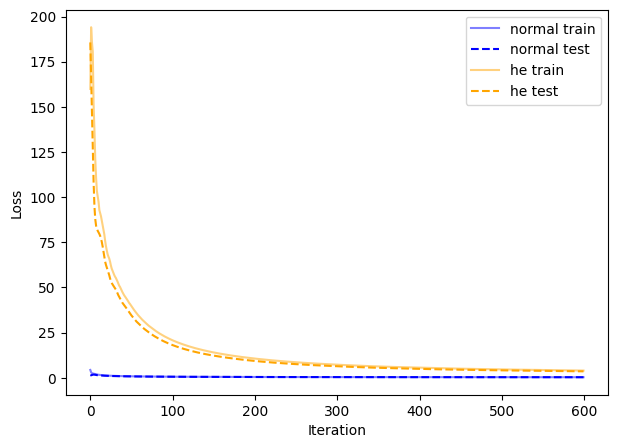

In [26]:
#@title Train & compare: Random (normal) vs He
epochs = 40
output_sizes = [64, 64, 1]
metrics_history_a = {"train_loss": [], "test_loss": []}
metrics_history_b = {"train_loss": [], "test_loss": []}

# (a) random normal
model_a, params_a, opt_a, state_a = get_model_and_optimizer(
    input_size=30, output_sizes=output_sizes, seed=0, lr=1e-3, init_type="normal", normal_std_val=0.05)
params_a, state_a, mh_a = train(epochs, params_a, model_a, opt_a, state_a,
                                loss_grad_fn, loss_func, train_ds, test_ds, metrics_history_a)

# (b) He
model_b, params_b, opt_b, state_b = get_model_and_optimizer(
    input_size=30, output_sizes=output_sizes, seed=0, lr=1e-3, init_type="he")
params_b, state_b, mh_b = train(epochs, params_b, model_b, opt_b, state_b,
                                loss_grad_fn, loss_func, train_ds, test_ds, metrics_history_b)

plot_metrics([mh_a, mh_b], ["normal", "he"])

### 2. Gradient Steps Optimisation

Even with good initialisation, **how** we step matters: the **learning rate** controls stability/speed; **momentum** helps traverse ravines; **Adam** adapts per-parameter step sizes with bias correction.


#### 2.1 Effect of Learning Rate

First, we’ll see plain gradient descent on a toy quadratic:
$$
f(\theta) = \tfrac12\,\theta^\top A \theta \quad(\text{convex})
$$
and visualise trajectories with different learning rates.

Then we’ll compare train/test curves for a small MLP on our dataset with **low**, **good**, and **high** learning rates.


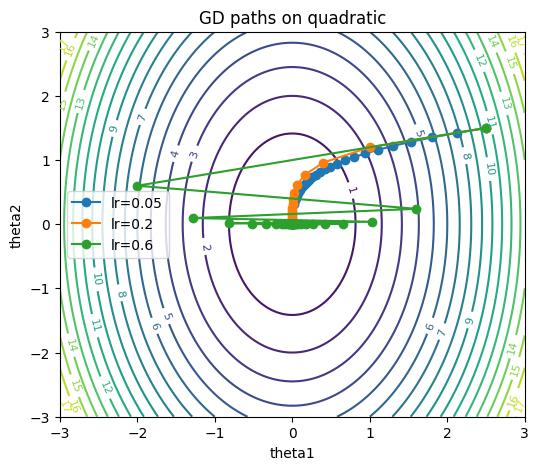

In [27]:
#@title Visualising GD paths on a 2D quadratic for different learning rates
import numpy as np
import matplotlib.pyplot as plt

A = np.array([[3., 0.], [0., 1.]])
def f(theta): return 0.5 * theta.T @ A @ theta
def grad(theta): return A @ theta

def gd(theta0, lr, steps=25):
    path = [theta0.copy()]
    theta = theta0.copy()
    for _ in range(steps):
        theta -= lr * grad(theta)
        path.append(theta.copy())
    return np.array(path)

thetas = {}
theta0 = np.array([2.5, 1.5])
for lr in [0.05, 0.2, 0.6]:
    thetas[lr] = gd(theta0, lr, steps=30)

# contour plot
xs = np.linspace(-3, 3, 200)
ys = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(xs, ys)
Z = 0.5*(3*X**2 + 1*Y**2)

plt.figure(figsize=(6,5))
cs = plt.contour(X, Y, Z, levels=20)
plt.clabel(cs, inline=1, fontsize=8)
for lr, path in thetas.items():
    plt.plot(path[:,0], path[:,1], marker='o', label=f"lr={lr}")
plt.legend(); plt.title("GD paths on quadratic")
plt.xlabel("theta1"); plt.ylabel("theta2")
plt.show()


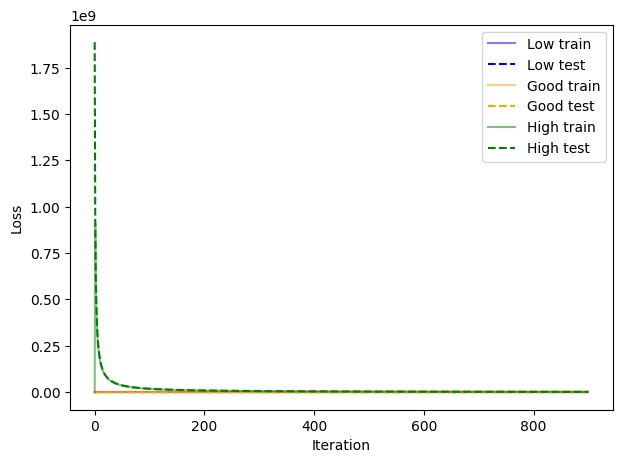

In [28]:
#@title Train small MLP with low/good/high learning rates (SGD)
def run_lr(lr):
    model, params, opt, state = get_model_and_optimizer(
        input_size=30, output_sizes=[32, 32, 1], seed=0, lr=lr, init_type="he")
    mh = {"train_loss": [], "test_loss": []}
    # swap optimizer to SGD for this experiment
    opt = optax.sgd(learning_rate=lr)
    state = opt.init(params)
    params2, state2, mh = train(epochs=30, params=params, model=model,
                                optimizer=opt, opt_state=state,
                                loss_grad_fn=loss_grad_fn, loss_fn=loss_func,
                                train_ds=train_ds, test_ds=test_ds,
                                metrics_history=mh)
    return mh

mh_low  = run_lr(1e-4)
mh_good = run_lr(1e-2)
mh_high = run_lr(5e-1)

plot_metrics([mh_low, mh_good, mh_high], ["Low", "Good", "High"])

#### 2.2 Momentum

**Update rule:**
$$
v_t = \beta v_{t-1} + (1-\beta)\,\nabla_\theta L(\theta),\quad
\theta \leftarrow \theta - \eta\, v_t
$$
Momentum accelerates along shallow valleys and damps oscillations.

**Exercise:** Add an `optimizer_name` switch to `get_model_and_optimizer` so we can choose `"sgd"`, `"momentum"`, or `"adam"` (default). For momentum, expose `beta` (e.g., 0.9).


In [ ]:
#@title EXERCISE: Add optimizer_name= {"sgd", "momentum", "adam"} to get_model_and_optimizer
def get_model_and_optimizer(input_size,
                            output_sizes=None,
                            seed=32,
                            lr=1e-3,
                            init_type="he",
                            optimizer_name="adam",
                            momentum_beta=0.9):
    # pick kernel_init (same as before)
    if init_type == "he":
        kernel_init = he_normal
    elif init_type == "xavier":
        kernel_init = xavier_normal
    elif init_type == "normal":
        kernel_init = normal_std(0.05)
    elif init_type == "uniform":
        kernel_init = uniform_range(0.05)
    else:
        kernel_init = nn.initializers.lecun_normal()

    model = MLP(output_sizes, kernel_init=kernel_init)
    key = jax.random.PRNGKey(seed)
    dummy = jnp.zeros((1, input_size), dtype=float)
    params = model.init(key, dummy)

    # TODO: select optimizer based on optimizer_name
    if optimizer_name == "sgd":
        optimizer = ...  # update me: optax.sgd(learning_rate=lr)
    elif optimizer_name == "momentum":
        optimizer = ...  # update me: optax.sgd(learning_rate=lr, momentum=momentum_beta, nesterov=False)
    else:
        optimizer = ...  # update me: optax.adam(learning_rate=lr)

    opt_state = optimizer.init(params)
    return model, params, optimizer, opt_state


In [29]:
#@title ✅ SOLUTION: optimizer_name switch
def get_model_and_optimizer(input_size,
                            output_sizes=None,
                            seed=32,
                            lr=1e-3,
                            init_type="he",
                            optimizer_name="adam",
                            momentum_beta=0.9):
    if init_type == "he":
        kernel_init = he_normal
    elif init_type == "xavier":
        kernel_init = xavier_normal
    elif init_type == "normal":
        kernel_init = normal_std(0.05)
    elif init_type == "uniform":
        kernel_init = uniform_range(0.05)
    else:
        kernel_init = nn.initializers.lecun_normal()

    model = MLP(output_sizes, kernel_init=kernel_init)
    key = jax.random.PRNGKey(seed)
    dummy = jnp.zeros((1, input_size), dtype=float)
    params = model.init(key, dummy)

    if optimizer_name == "sgd":
        optimizer = optax.sgd(learning_rate=lr)
    elif optimizer_name == "momentum":
        optimizer = optax.sgd(learning_rate=lr, momentum=momentum_beta, nesterov=False)
    else:
        optimizer = optax.adam(learning_rate=lr)

    opt_state = optimizer.init(params)
    return model, params, optimizer, opt_state


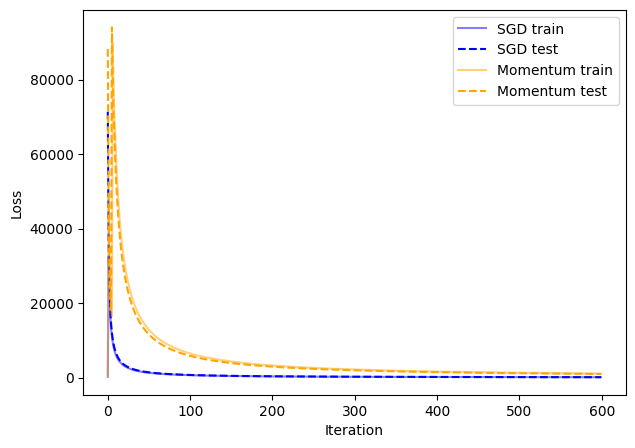

In [30]:
#@title Demo: Visual momentum effect on our dataset
epochs = 40
cfgs = [
    ("SGD",       dict(optimizer_name="sgd", lr=1e-2)),
    ("Momentum",  dict(optimizer_name="momentum", lr=1e-2, momentum_beta=0.9)),
]
histories = []
methods = []
for name, kwargs in cfgs:
    model, params, opt, state = get_model_and_optimizer(
        input_size=30, output_sizes=[64,64,1], seed=0, init_type="he", **kwargs)
    mh = {"train_loss": [], "test_loss": []}
    params, state, mh = train(epochs, params, model, opt, state,
                              loss_grad_fn, loss_func, train_ds, test_ds, mh)
    histories.append(mh)
    methods.append(name)

plot_metrics(histories, methods)

#### 2.3 Adam Optimizer

Adam maintains **exponentially decaying moving averages** of gradients and squared gradients and applies **bias correction**:

**Pseudocode:**



**Exercise:** Using the `optimizer_name` switch you added, instantiate Adam and compare **SGD vs. Momentum vs. Adam**.


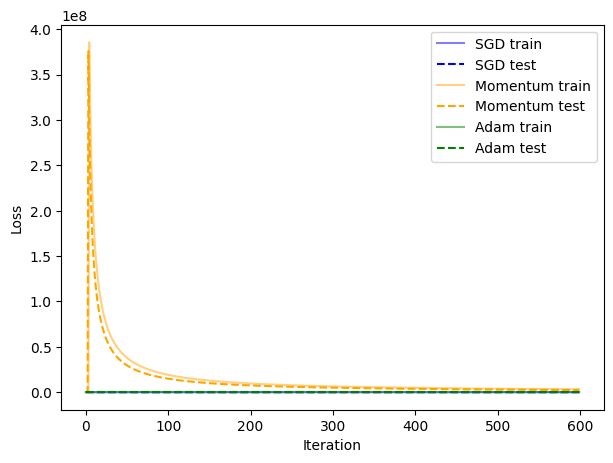

In [31]:
#@title ✅ SOLUTION: Compare SGD / Momentum / Adam side-by-side
epochs = 40
cfgs = [
    ("SGD",      dict(optimizer_name="sgd", lr=1e-2)),
    ("Momentum", dict(optimizer_name="momentum", lr=1e-2, momentum_beta=0.9)),
    ("Adam",     dict(optimizer_name="adam", lr=1e-3)),
]

histories = []
methods = []
for name, kwargs in cfgs:
    model, params, opt, state = get_model_and_optimizer(
        input_size=30, output_sizes=[64,64,1], seed=1, init_type="he", **kwargs)
    mh = {"train_loss": [], "test_loss": []}
    params, state, mh = train(epochs, params, model, opt, state,
                              loss_grad_fn, loss_func, train_ds, test_ds, mh)
    histories.append(mh)
    methods.append(name)

plot_metrics(histories, methods)


### 3. Regularisation

Regularisation discourages overly complex solutions that overfit the training data. We’ll implement **L2/weight decay** and **early stopping**, then briefly list other useful methods.

> Reference slides: **CM20315 Regularization slides** (add your link here).


#### 3.1 L2 Regularisation (Weight Decay)

**Objective:**
$$
L_{\text{reg}}(\theta) = L_{\text{data}}(\theta) + \lambda \|\theta\|_2^2
$$

**Probabilistic view:** Equivalent to a **Gaussian prior** on weights $ \theta \sim \mathcal{N}(0,\ \sigma^2 I) $, where $\lambda \propto 1/\sigma^2$.

**Exercise:** Modify `loss_func` to add L2 penalty over all parameters when `weight_decay > 0`. Keep the original return signature `(loss, logits)`.


In [ ]:
#@title EXERCISE: Add weight decay to loss_func
def loss_func(params, model, batch, weight_decay=0.0):
    """
    Compute BCE loss + optional L2 penalty (weight decay).
    Returns: (loss, logits)
    """
    x, y = batch
    # 1) logits
    logits = ...  # update me: model.apply({"params": params["params"]}, x)
    y = jnp.reshape(jnp.array(y), logits.shape)

    # 2) BCE with logits
    bce = jnp.mean(optax.sigmoid_binary_cross_entropy(logits, y))

    # 3) L2 penalty across all params if weight_decay > 0
    if weight_decay > 0:
        def sqsum(tree):
            return sum([jnp.sum(jnp.square(v)) for v in jax.tree_util.tree_leaves(tree)])
        l2 = ...  # update me: sqsum(params["params"])
    else:
        l2 = 0.0

    loss = bce + weight_decay * l2
    return loss, logits

# and its gradient fn
loss_grad_fn = jax.value_and_grad(lambda p, m, batch: loss_func(p, m, batch)[0:2], has_aux=True)


In [32]:
#@title ✅ SOLUTION: L2 weight decay in loss_func
def loss_func(params, model, batch, weight_decay=0.0):
    x, y = batch
    logits = model.apply({"params": params["params"]}, jnp.array(x.to_numpy()) if hasattr(x, "to_numpy") else x)
    y = jnp.reshape(jnp.array(y), logits.shape)

    bce = jnp.mean(optax.sigmoid_binary_cross_entropy(logits, y))

    l2 = 0.0
    if weight_decay > 0:
        def sqsum(tree):
            return sum([jnp.sum(jnp.square(v)) for v in jax.tree_util.tree_leaves(tree)])
        l2 = sqsum(params["params"])

    loss = bce + weight_decay * l2
    return loss, logits

loss_grad_fn = jax.value_and_grad(lambda p, m, batch: loss_func(p, m, batch)[0:2], has_aux=True)


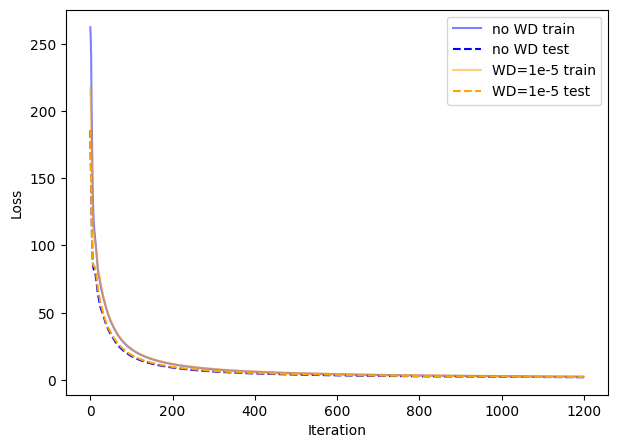

Test accuracy (no WD): 0.8246
Test accuracy (WD=1e-5): 0.9123


In [33]:
#@title Practical: train with/without L2 and compare test accuracy
def predict(params, model, x, threshold=0.5):
    logits = model.apply({"params": params["params"]}, jnp.array(x.to_numpy()) if hasattr(x, "to_numpy") else x)
    probs = jax.nn.sigmoid(logits)
    preds = (probs >= threshold).astype(jnp.int32)
    return preds.squeeze()

def evaluate_accuracy(params, model, x, y):
    yhat = predict(params, model, x)
    ytrue = jnp.array(y.to_numpy() if hasattr(y, "to_numpy") else y)
    return (yhat == ytrue).mean()

epochs = 80
output_sizes = [64,64,1]

# no weight decay
model0, params0, opt0, state0 = get_model_and_optimizer(30, output_sizes, seed=0, init_type="he", optimizer_name="adam", lr=1e-3)
mh0 = {"train_loss": [], "test_loss": []}
params0, state0, mh0 = train(epochs, params0, model0, opt0, state0,
                             loss_grad_fn, lambda p,m,b: loss_func(p,m,b,weight_decay=0.0),
                             train_ds, test_ds, mh0)
acc0 = float(evaluate_accuracy(params0, model0, x_test, y_test))

# with weight decay
model1, params1, opt1, state1 = get_model_and_optimizer(30, output_sizes, seed=0, init_type="he", optimizer_name="adam", lr=1e-3)
mh1 = {"train_loss": [], "test_loss": []}
params1, state1, mh1 = train(epochs, params1, model1, opt1, state1,
                             loss_grad_fn, lambda p,m,b: loss_func(p,m,b,weight_decay=1e-5),
                             train_ds, test_ds, mh1)

plot_metrics([mh0, mh1], ["no WD", "WD=1e-5"])
acc1 = float(evaluate_accuracy(params1, model1, x_test, y_test))

print(f"Test accuracy (no WD): {acc0:.4f}")
print(f"Test accuracy (WD=1e-5): {acc1:.4f}")


#### 3.2 Early Stopping

**Idea:** Stop training when validation loss stops improving for some **patience**. This reduces the *effective capacity* and helps generalisation.

We’ll add a simple early-stopping wrapper.  

**Exercise (Easy):** Implement `train_with_early_stopping` with `patience` and `min_delta`. Save the **best** parameters (lowest test loss).


In [ ]:
#@title EXERCISE: Early stopping training loop
def train_with_early_stopping(epochs, params, model, optimizer, opt_state,
                              loss_grad_fn, loss_fn, train_ds, test_ds,
                              metrics_history, patience=10, min_delta=0.0):
    best_loss = jnp.inf
    best_params = params
    wait = 0

    for i in range(epochs):
        train_metrics = TrainMetrics.empty()
        for batch in train_ds.as_numpy_iterator():
            params, opt_state, train_metrics = train_step(params, model, optimizer, opt_state, loss_grad_fn, train_metrics, batch)
        for metric, value in train_metrics.compute().items():
            metrics_history[f"train_{metric}"].append(value)

        eval_metrics = EvalMetrics.empty()
        for batch in test_ds.as_numpy_iterator():
            eval_metrics = eval_step(params, model, loss_fn, eval_metrics, batch)
        # get current validation loss
        val_loss = ...  # update me: list(eval_metrics.compute().items())[0][1] or eval_metrics.compute()["loss"]
        metrics_history["test_loss"].append(val_loss)

        # early stopping check
        if best_loss - val_loss > min_delta:
            best_loss = val_loss
            best_params = ...  # update me
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {i+1}. Best val loss={float(best_loss):.4f}")
                break

    return best_params, opt_state, metrics_history


In [34]:
#@title ✅ SOLUTION: Early stopping training loop
def train_with_early_stopping(epochs, params, model, optimizer, opt_state,
                              loss_grad_fn, loss_fn, train_ds, test_ds,
                              metrics_history, patience=10, min_delta=0.0):
    best_loss = jnp.inf
    best_params = params
    wait = 0

    for i in range(epochs):
        train_metrics = TrainMetrics.empty()
        for batch in train_ds.as_numpy_iterator():
            params, opt_state, train_metrics = train_step(params, model, optimizer, opt_state, loss_grad_fn, train_metrics, batch)
        for metric, value in train_metrics.compute().items():
            metrics_history[f"train_{metric}"].append(value)

        eval_metrics = EvalMetrics.empty()
        for batch in test_ds.as_numpy_iterator():
            eval_metrics = eval_step(params, model, loss_fn, eval_metrics, batch)

        cur = eval_metrics.compute()
        val_loss = cur["loss"] if "loss" in cur else list(cur.values())[0]
        metrics_history["test_loss"].append(val_loss)

        if best_loss - val_loss > min_delta:
            best_loss = val_loss
            best_params = params
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {i+1}. Best val loss={float(best_loss):.4f}")
                break

    return best_params, opt_state, metrics_history


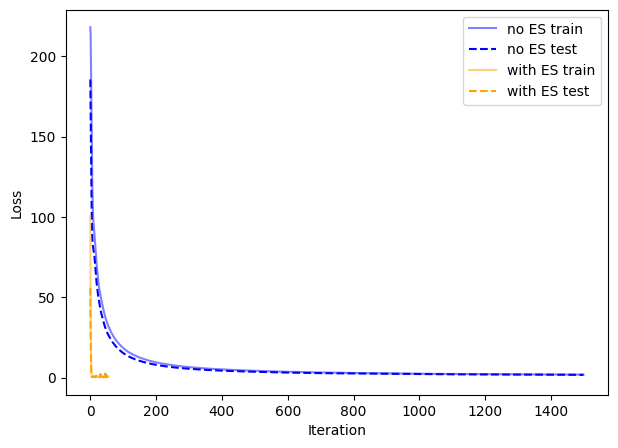

Test accuracy (no ES): 0.8158
Test accuracy (with ES): 0.9474


In [35]:
#@title Compare with vs. without early stopping
epochs = 100
output_sizes = [64,64,1]

# baseline long training (no ES)
model_a, params_a, opt_a, state_a = get_model_and_optimizer(30, output_sizes, seed=0, init_type="he", optimizer_name="adam", lr=1e-3)
mh_a = {"train_loss": [], "test_loss": []}
params_a, state_a, mh_a = train(epochs, params_a, model_a, opt_a, state_a,
                                loss_grad_fn, loss_func, train_ds, test_ds, mh_a)
acc_a = float(evaluate_accuracy(params_a, model_a, x_test, y_test))

# with ES
model_b, params_b, opt_b, state_b = get_model_and_optimizer(30, output_sizes, seed=0, init_type="he", optimizer_name="adam", lr=1e-3)
mh_b = {"train_loss": [], "test_loss": []}
best_params_b, state_b, mh_b = train_with_early_stopping(
    epochs, params_b, model_b, opt_b, state_b,
    loss_grad_fn, loss_func, train_ds, test_ds, mh_b,
    patience=15, min_delta=1e-4)
acc_b = float(evaluate_accuracy(best_params_b, model_b, x_test, y_test))
plot_metrics([mh_a, mh_b], ["no ES", "with ES"])

print(f"Test accuracy (no ES): {acc_a:.4f}")
print(f"Test accuracy (with ES): {acc_b:.4f}")


#### 3.3 Other approaches (briefly)

- **Dropout:** Randomly zero out activations during training to reduce co-adaptation.  
- **Ensembling:** Average predictions from multiple models.  
- **Noise injection:** Add noise to inputs/weights/gradients.  
- **Bayesian approaches:** Place priors over parameters and infer posteriors.  
- **Transfer learning / Multi-task learning:** Share representations to regularise.  
- **Self-supervised pretraining:** Better initial representations → less overfitting.  
- **Data augmentation:** Domain-appropriate transforms that preserve labels.

> Try these as stretch tasks: add dropout layers to the MLP, or augment features if you had images/text/time-series data.

<img src="https://lh3.googleusercontent.com/d/1wDmuNI-kTziT5ZUFxhpstCRkjOE9obSr" width="1000"/>



### Wrap-up

- **Initialisation** affects signal propagation and convergence — He works well with ReLU/GELU.  
- **Optimisers** trade stability and speed — Momentum and Adam generally accelerate training.  
- **Regularisation** (L2, early stopping, …) improves generalisation.

**Next:** You can extend this part with **learning-rate schedules** (e.g., cosine, step decay) and **hyperparameter sweeps** (grid/random/Bayesian) to complete the section promised in your outline.


## Appendix


### References
1. Flax module documentation: https://flax-linen.readthedocs.io/en/latest/api_reference/flax.linen/module.html


## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/CJCNwwcLW9Y3jZDG7",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />